In [1]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight




In [7]:

# Read the CSV file into a DataFrame
df = pd.read_csv('2021plus_data_v1.csv')

# Separate features and target variable
X = df.drop('POSTSEASON', axis=1)  # Features
y = df['POSTSEASON']  # Target variable

# Define categorical columns for encoding
categorical_columns = ['TeamName', 'CONF']

# Define the preprocessing steps for numerical and categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', X.select_dtypes(include=['int64', 'float64']).columns),  # Pass through numerical columns
        ('cat', OneHotEncoder(), categorical_columns)  # One-hot encode categorical columns
    ])

# Define the pipeline including preprocessing and Random Forest classifier
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))])

# Fit the pipeline to the data
pipeline.fit(X, y)

# Get feature importances
if hasattr(pipeline.named_steps['classifier'], 'feature_importances_'):
    feature_importances = pipeline.named_steps['classifier'].feature_importances_
else:
    # For models like SVM which don't have feature importances
    feature_importances = None

# If feature importances are available, create a DataFrame to display them
if feature_importances is not None:
    # Get numerical column names after one-hot encoding
    numerical_columns = preprocessor.transformers_[0][2]
    # Get one-hot encoded feature names for categorical columns
    categorical_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(input_features=categorical_columns)
    # Combine numerical and categorical feature names
    feature_names = list(numerical_columns) + list(categorical_feature_names)

    # Create a DataFrame to display feature importances
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

    # Sort the DataFrame by importance values in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Print the top features
    print("Top features for predicting 'POSTSEASON':")
    print(feature_importance_df)

    # Optionally, you can save the feature importances to a file
    feature_importance_df.to_csv('feature_importances.csv', index=False)
else:
    print("Feature importances are not available for the classifier used.")


Top features for predicting 'POSTSEASON':
                     Feature  Importance
12                     AdjEM    0.056418
17                         G    0.047319
22                       WAB    0.046761
11                     AdjDE    0.043167
23                      SEED    0.041850
..                       ...         ...
170                CONF_MEAC    0.000000
147        TeamName_Winthrop    0.000000
79         TeamName_Longwood    0.000000
152            TeamName_Yale    0.000000
137  TeamName_UNC Greensboro    0.000000

[185 rows x 2 columns]


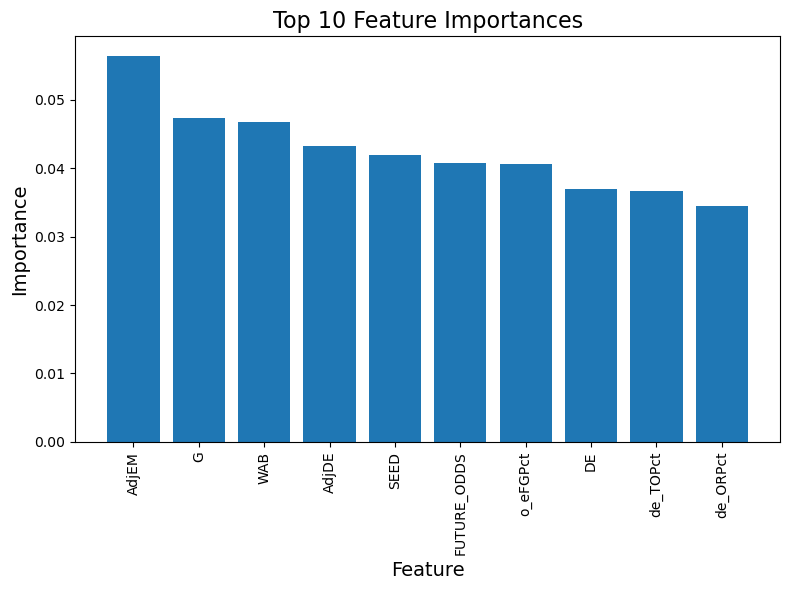

In [8]:
if feature_importances is not None:
    # Get numerical column names after one-hot encoding
    numerical_columns = preprocessor.transformers_[0][2]
    # Get one-hot encoded feature names for categorical columns
    categorical_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(input_features=categorical_columns)
    # Combine numerical and categorical feature names
    feature_names = list(numerical_columns) + list(categorical_feature_names)

    # Create a DataFrame to display feature importances
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

    # Sort the DataFrame by importance values in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Select the top 10 most important features
    top_features = feature_importance_df.head(10)

    # Plot the top 10 feature importances as a bar graph
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bar(top_features['Feature'], top_features['Importance'])
    ax.set_title('Top 10 Feature Importances', fontsize=16)
    ax.set_xlabel('Feature', fontsize=14)
    ax.set_ylabel('Importance', fontsize=14)
    ax.tick_params(axis='x', rotation=90)
    plt.tight_layout()
    plt.show()

    # Optionally, you can save the top feature importances to a file
    top_features.to_csv('top_feature_importances.csv', index=False)
else:
    print("Feature importances are not available for the classifier used.")

In [9]:
# Load the dataset
data = pd.read_csv('2021plus_data_v1.csv')
data = data[["TeamName", "CONF", "POSTSEASON", "AdjEM", "de_ORPct", "de_TOPct", "de_FTRate", "Def_3", "W", "AdjEM", "OE", "AdjDE", "Tempo", "o_ORPct"]]

# One-hot encode the 'CONF' column
conf_dummies = pd.get_dummies(data['CONF'], prefix='CONF')
data = pd.concat([data, conf_dummies], axis=1)
data = data.drop('CONF', axis=1)

# Separate the target variable and features
X = data.drop(['POSTSEASON', 'TeamName'], axis=1)
y = data['POSTSEASON']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a list of team names for the test set instances
test_team_names = data['TeamName'].iloc[X_test.index].tolist()

# Create an instance of OneHotEncoder for the categorical features
cat_cols = np.array(conf_dummies.columns)
one_hot_encoder = OneHotEncoder(categories='auto', handle_unknown='ignore')

# One-hot encode the categorical features in the training set
X_train_cat = X_train[cat_cols]
X_train_cat = one_hot_encoder.fit_transform(X_train_cat).toarray()

# One-hot encode the categorical features in the test set
X_test_cat = X_test[cat_cols]
X_test_cat = one_hot_encoder.transform(X_test_cat).toarray()

# Concatenate the one-hot encoded categorical features with the numerical features
X_train_num = X_train.drop(cat_cols, axis=1)
X_train = np.concatenate([X_train_num, X_train_cat], axis=1)
X_test_num = X_test.drop(cat_cols, axis=1)
X_test = np.concatenate([X_test_num, X_test_cat], axis=1)

# Standardize the numerical features
scaler = StandardScaler()
X_train[:, :-len(cat_cols)] = scaler.fit_transform(X_train[:, :-len(cat_cols)])
X_test[:, :-len(cat_cols)] = scaler.transform(X_test[:, :-len(cat_cols)])

# Compute the class weights
class_labels = ['2ND', 'Champions', 'E8', 'F4', 'R32', 'R64', 'R68', 'S16']
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=class_labels, y=y_train)

# Create a dictionary mapping class labels to their weights
unique_classes = np.unique(y_train)
class_weight_dict = dict(zip(unique_classes, class_weights))


minority_class_weights = {
    '2ND': class_weights[0] * 2,
    'Champions': class_weights[1] * 2,
    'E8': class_weights[2] * 2,
    'F4': class_weights[3] * 2,
    'R68': class_weights[6] * 2
}
class_weight_dict.update(minority_class_weights)






# Define the hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],  # Kernel type
    'gamma': ['scale', 'auto', 0.1, 1, 10],  # Kernel coefficient
    'degree': [2, 3, 4],  # Degree for polynomial kernel
    'coef0': [0, 0.1, 1, 10],  # Independent term in polynomial kernel
    'class_weight': [class_weight_dict, None]  # Class weights or no class weights
}

# Create an instance of GridSearchCV
grid_search = GridSearchCV(estimator=SVC(), param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best accuracy score: ", grid_search.best_score_)

# Create an SVM model with the best hyperparameters
svm_model = grid_search.best_estimator_

# Train the SVM model on the training data
svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test)

# Evaluate the model
from sklearn.metrics import classification_report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Create a DataFrame to display team names, actual labels, and predicted labels
test_teams = pd.DataFrame({'TeamName': test_team_names, 'Actual': y_test, 'Predicted': y_pred})

# Print the team names, actual labels, and predicted labels
print("\nTeam Names, Actual Labels, and Predicted Labels:")
print(test_teams)

/Users/avikhurana/miniconda3/envs/cs373/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best hyperparameters:  {'C': 0.01, 'class_weight': None, 'coef0': 10, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}
Best accuracy score:  0.5399621212121212
Classification Report:
               precision    recall  f1-score   support

   Champions       0.00      0.00      0.00         1
          E8       0.00      0.00      0.00         5
          F4       0.00      0.00      0.00         1
         R32       0.60      0.43      0.50         7
         R64       0.56      0.90      0.69        20
         R68       0.00      0.00      0.00         2
         S16       0.33      0.20      0.25         5

    accuracy                           0.54        41
   macro avg       0.21      0.22      0.21        41
weighted avg       0.42      0.54      0.45        41


Team Names, Actual Labels, and Predicted Labels:
                   TeamName     Actual Predicted
15                   Furman        R32       R64
9               Connecticut  Champions       S16
115           Saint Pe

/Users/avikhurana/miniconda3/envs/cs373/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/avikhurana/miniconda3/envs/cs373/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/avikhurana/miniconda3/envs/cs373/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

In [46]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from collections import Counter



new_data = pd.read_csv('2024_data_v4.csv')
data = pd.read_csv('2021plus_data_v1.csv')
data = data[data['TeamName'] != 'Purdue']



In [49]:


# Find the common columns between the two datasets
common_cols = list(set(new_data.columns) & set(data.columns))
# Remove 'POSTSEASON' and 'TeamName' from the common columns
common_cols = [col for col in common_cols if col not in ['POSTSEASON', 'TeamName']]

# Select the common columns from the training data
X = data[common_cols]
y = data['POSTSEASON']

# Separate numerical and categorical columns
cat_cols = X.columns[X.dtypes.apply(lambda x: x == 'object')].tolist()
num_cols = X.columns[X.dtypes.apply(lambda x: x != 'object')].tolist()

# One-hot encode the categorical features in the training data
if cat_cols:
    one_hot_encoder = OneHotEncoder(categories='auto', handle_unknown='ignore')
    X_cat = one_hot_encoder.fit_transform(X[cat_cols]).toarray()
    X_num = X[num_cols].values
    X = np.concatenate([X_num, X_cat], axis=1)
else:
    X = X.values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear'],  # Kernel type
    'gamma': ['scale', 'auto', 0.1, 1, 10],  # Kernel coefficient
    'degree': [2, 3, 4],  # Degree for polynomial kernel
    'coef0': [0, 0.1, 1, 10],  # Independent term in polynomial kernel
}

# Create an instance of SVC
svm = SVC(probability=True)

# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best estimator and its parameters
best_svm = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

/Users/avikhurana/miniconda3/envs/cs373/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best parameters: {'C': 0.1, 'coef0': 0, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}


Classification Report:
               precision    recall  f1-score   support

   Champions       0.00      0.00      0.00         1
          E8       0.00      0.00      0.00         3
          F4       0.00      0.00      0.00         1
         R32       0.06      0.17      0.09         6
         R64       0.64      0.80      0.71        20
         R68       0.00      0.00      0.00         2
         S16       0.00      0.00      0.00         8

    accuracy                           0.41        41
   macro avg       0.10      0.14      0.11        41
weighted avg       0.32      0.41      0.36        41

Accuracy on the test set (top 3 features): 0.4146


/Users/avikhurana/miniconda3/envs/cs373/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/avikhurana/miniconda3/envs/cs373/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/avikhurana/miniconda3/envs/cs373/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

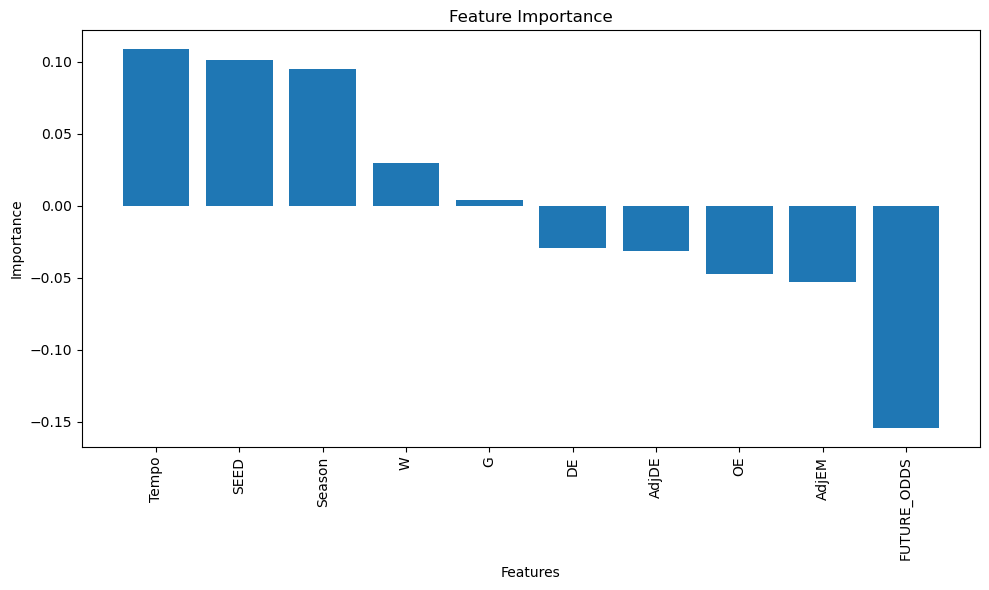

In [50]:


# Calculate feature importance
feature_importances = best_svm.coef_[0]
feature_names = common_cols

# Sort feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_features = [feature_names[i] for i in sorted_indices]
sorted_importances = feature_importances[sorted_indices]


# Create a feature importance plot
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_features)), sorted_importances, align='center')
plt.xticks(range(len(sorted_features)), sorted_features, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')

# Use only the top 3 features for training
X_train_top3 = X_train[:, sorted_indices[:3]]
X_test_top3 = X_test[:, sorted_indices[:3]]

# Train the model with the top 3 features
best_svm.fit(X_train_top3, y_train)

# Predictions on the test set
y_pred = best_svm.predict(X_test_top3)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Calculate accuracy on the test set
accuracy = best_svm.score(X_test_top3, y_test)
print(f"Accuracy on the test set (top 3 features): {accuracy:.4f}")

In [51]:

# Prepare the new data for prediction
new_X = new_data[common_cols]
if cat_cols:
    new_X_cat = new_X[cat_cols]
    new_X_cat = one_hot_encoder.transform(new_X_cat).toarray()
    new_X_num = new_X[num_cols].values
    new_X = np.concatenate([new_X_num, new_X_cat], axis=1)
else:
    new_X = new_X.values
new_X = scaler.transform(new_X)
new_X_top3 = new_X[:, sorted_indices[:3]]

In [52]:
# Make predictions on the new data
new_y_pred = best_svm.predict(new_X_top3)
new_y_prob = best_svm.predict_proba(new_X_top3)

# Define the desired counts for each class
desired_counts = {
    'R68': 4, 'R64': 32, 'R32': 16, 'S16': 8,
    'E8': 4, 'F4': 2, '2ND': 1, 'Champions': 1
}

# Sort the classes based on the order you provided
ordered_classes = ['R68', 'R64', 'R32', 'S16', 'E8', 'F4', '2ND', 'Champions']

# Initialize the new predictions
new_y_pred_final = [None] * len(new_y_pred)

# Fill each class with the teams having the highest probabilities
for cls in ordered_classes:
    remaining_slots = desired_counts[cls]
    class_probs = new_y_prob[:, ordered_classes.index(cls)]
    top_indices = np.argsort(class_probs)[::-1]

    for idx in top_indices:
        if remaining_slots > 0 and new_y_pred_final[idx] is None:
            new_y_pred_final[idx] = cls
            remaining_slots -= 1

# Create a DataFrame with the team names and predicted labels
new_teams = pd.DataFrame({'TeamName': new_data['TeamName'], 'Predicted': new_y_pred_final})
new_teams.to_csv('predictions.csv', index=False)